In [1]:
# all hyperparameters taken from https://www.sciencedirect.com/science/article/pii/S0165027020303095

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [100]:
left = []
right = []

with open('motion_gui_logs_rachel_4.pickle', 'rb') as f:
    file = pickle.load(f)
    
    event_array = file['EVENT_LOG']
    signal_array = file['DATA_LOG']
    
    j = 0
    for i in tqdm(range(len(event_array)-1)):
        
        event_data = vars(event_array[i])
        next_event_data = vars(event_array[i+1])
        
        # initial time for that event
        time_0 = event_data['timestamp']
        
        # array to store signal for that event
        event_signal = np.array([])
        
        # loop through signal array. While timestamp is less than timestamp
        # of the next event, add it to the current event signal
        while signal_array[j]['time'] <= next_event_data['timestamp']:
            
            # number of points at that timestamp
            n_samples = signal_array[j]['data'].shape[1]
            
            # spread out time between this timestamp and the next
            times = np.linspace(signal_array[j]['time'], signal_array[j+1]['time'], n_samples)
            
            # map each time to a list of channel values
            for time, channel_values in zip(times, signal_array[j]['data'][1:9].T):

                # signal at this event timestamp
                signal_at_time = np.array([])

                # populate the current signal array
                for channel in channel_values:
                    point = np.array([time - time_0, channel])
                    signal_at_time = np.vstack((signal_at_time, point)) \
                                            if signal_at_time.size else point
                    
                # add another dimension to signal_at_time for formatting
                signal_at_time = np.expand_dims(signal_at_time, axis=1)
                    
                # add the signal at the current time to the event signal
                event_signal = np.concatenate((event_signal, signal_at_time), axis=1) \
                                            if event_signal.size else signal_at_time
            
            # next timestamp in signal array
            j += 1
            
        # add it to either left or right data
        if event_signal.size == 0:
            continue
  
        if event_data['task'] == 'LEFT':
            left.append(event_signal[:752])
                
        elif event_data['task'] == 'RIGHT':
            right.append(event_signal[:752])
                
    # add remaining not needed since last event is end


100%|█████████████████████████████████████████| 105/105 [00:04<00:00, 22.90it/s]


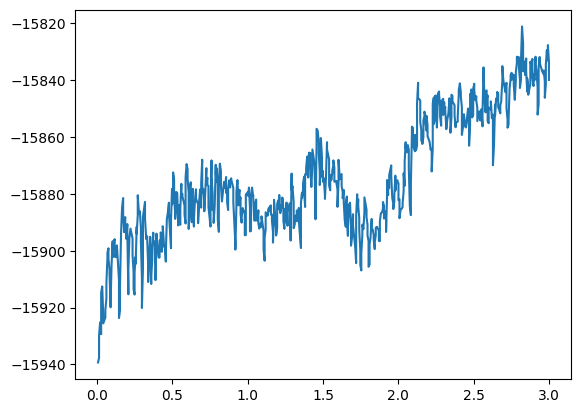

In [101]:
# format: left[event_number][channel_number][index][time, value]

# Let's extract a single channel from a single event
t = left[0][7][:, 0]
x = left[0][7][:, 1]

plt.plot(t, x)

Text(0.5, 1.0, 'Filtered Data')

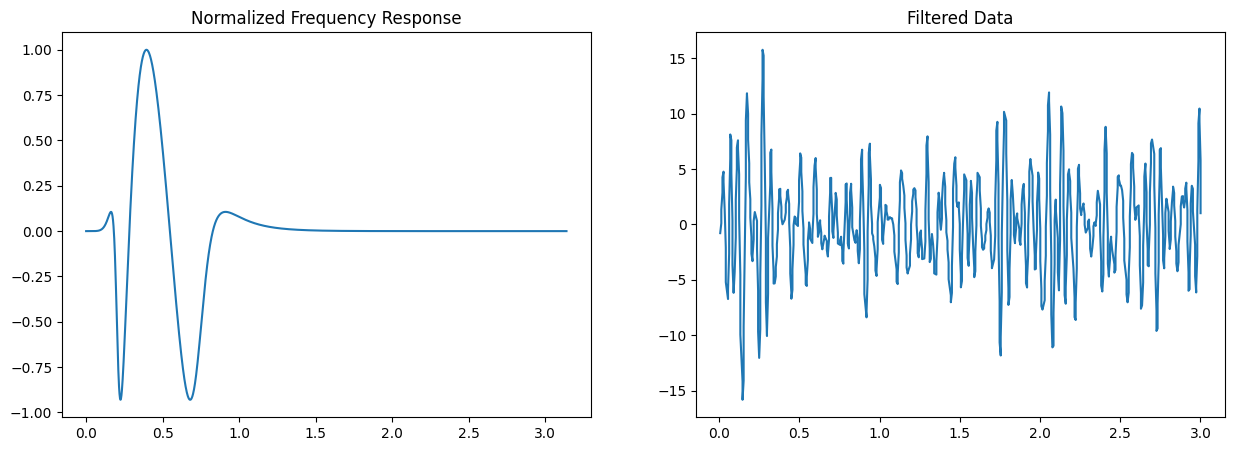

In [102]:
# Butterworth Bandpass Filter
# Taken from https://stackoverflow.com/a/48677312

from scipy.signal import butter, freqz, sosfiltfilt, sosfreqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 250
lowcut = 8
highcut = 30

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

sos = butter_bandpass(lowcut, highcut, fs)
w, h = sosfreqz(sos, worN=2000)

y = butter_bandpass_filter(x, lowcut, highcut, fs)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].plot(w, h)
ax[0].set_title("Normalized Frequency Response")

ax[1].plot(t, y)
ax[1].set_title("Filtered Data")

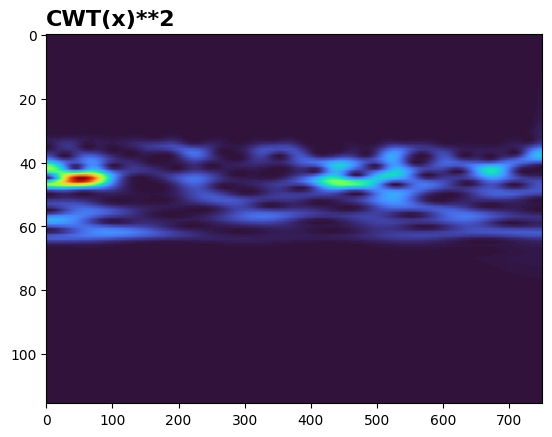

In [103]:
# Continuous Wavelet Transform
# Taken from https://dsp.stackexchange.com/a/87760

from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import plot, imshow

wavelet = Wavelet(('gmw', {'gamma': 3, 'beta': 60}))

# configure
def generate_cwt(data):
    signal_length = len(data)

    # make scales
    min_scale, max_scale = cwt_scalebounds(wavelet, signal_length)
    scales = make_scales(signal_length, scaletype='log-piecewise', nv=16, # log-piecewise and 16 voices recommended by library
                         min_scale=min_scale, max_scale=max_scale, wavelet=wavelet)

    # make filterbank
    fbank = wavelet(scale=scales)

    # take CWT
    wx, _ = cwt(data, wavelet, scales=scales)

    # square it
    wx = wx ** 2

    # visualize
    # plot(fbank.T, show=1, title="CWT filterbank")
    # imshow(wx, title="CWT(x)**2", abs=True)
    
    return np.abs(wx)

wx = generate_cwt(y)
imshow(wx, title="CWT(x)**2", abs=True)

100%|███████████████████████████████████████████| 26/26 [00:04<00:00,  6.12it/s]


0


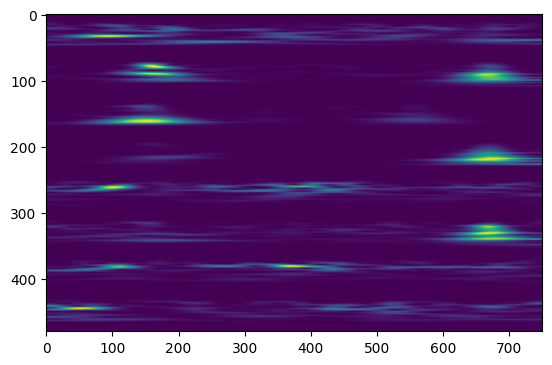

In [104]:
import cv2

# cz = 0
# fc = 1
# p4 = 2
# p3 = 3
# f4 = 4
# f3 = 5
# c4 = 6
# c3 = 7

fs = 250
lowcut = 8
highcut = 30

# format: left[event_number][channel_number][index][time, value]

images = []
labels = []

for event in tqdm(left):
    img = np.array([])

    for channel in range(8): # channels:
        x = event[channel][:, 1]

        filtered = butter_bandpass_filter(x, lowcut, highcut, fs)
        wt = generate_cwt(filtered)[20:80]

        cv2.normalize(wt, wt, 0, 255, cv2.NORM_MINMAX)

        if img.size:
            img = np.vstack((img, wt))
        else:
            img = wt

    images.append(img)
    labels.append(0)
    
for event in tqdm(right):
    img = np.array([])

    for channel in range(8): # channels:
        x = event[channel][:, 1]

        filtered = butter_bandpass_filter(x, lowcut, highcut, fs)
        wt = generate_cwt(filtered)[20:80]

        cv2.normalize(wt, wt, 0, 255, cv2.NORM_MINMAX)

        if img.size:
            img = np.vstack((img, wt))
        else:
            img = wt

    images.append(img)
    labels.append(1)
    
plt.imshow(images[0])
print(labels[0])

In [105]:
indices = np.arange(len(images))
np.random.shuffle(indices)

In [106]:
import cv2
import time

left_counter = 0
right_counter = 0

test_size = 6

for i in indices:
    img = images[i]
    label = labels[i]
    
    # left
    if label == 0:
        # test
        if left_counter < test_size:
            cv2.imwrite(f"./data/test/left/{time.time()}.jpg", img)
        # train
        else:
            cv2.imwrite(f"./data/train/left/{time.time()}.jpg", img)
            
        left_counter += 1
            
    # right
    else:
        # test
        if right_counter < test_size:
            cv2.imwrite(f"./data/test/right/{time.time()}.jpg", img)
        # train
        else:
            cv2.imwrite(f"./data/train/right/{time.time()}.jpg", img)
    
        right_counter += 1